# Report

In [2]:
import cv2 as cv
import numpy as np
import sys
import os
import subprocess
import matplotlib.pyplot as plt
from tqdm import tqdm

## Example

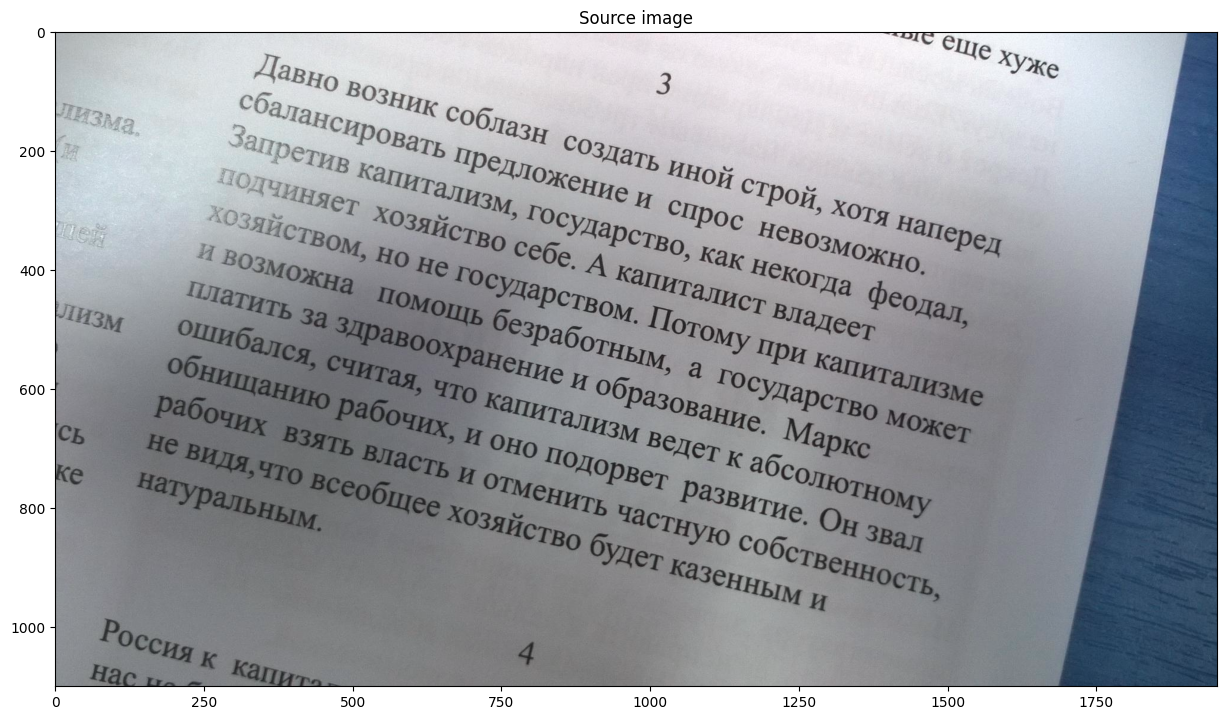

In [3]:
src_path = "images/1.jpg"
src = cv.imread(src_path)

plt.figure(figsize=(15,15))
plt.title("Source image")
plt.imshow(src)

In [6]:
args = ["./cmake-build-debug/FHT", src_path, "drt.jpg"]
output = subprocess.run(args, shell=False, capture_output=True)
print(output.stdout.decode("utf-8"))

Slope angle: -10
FHT time: 1467 ms



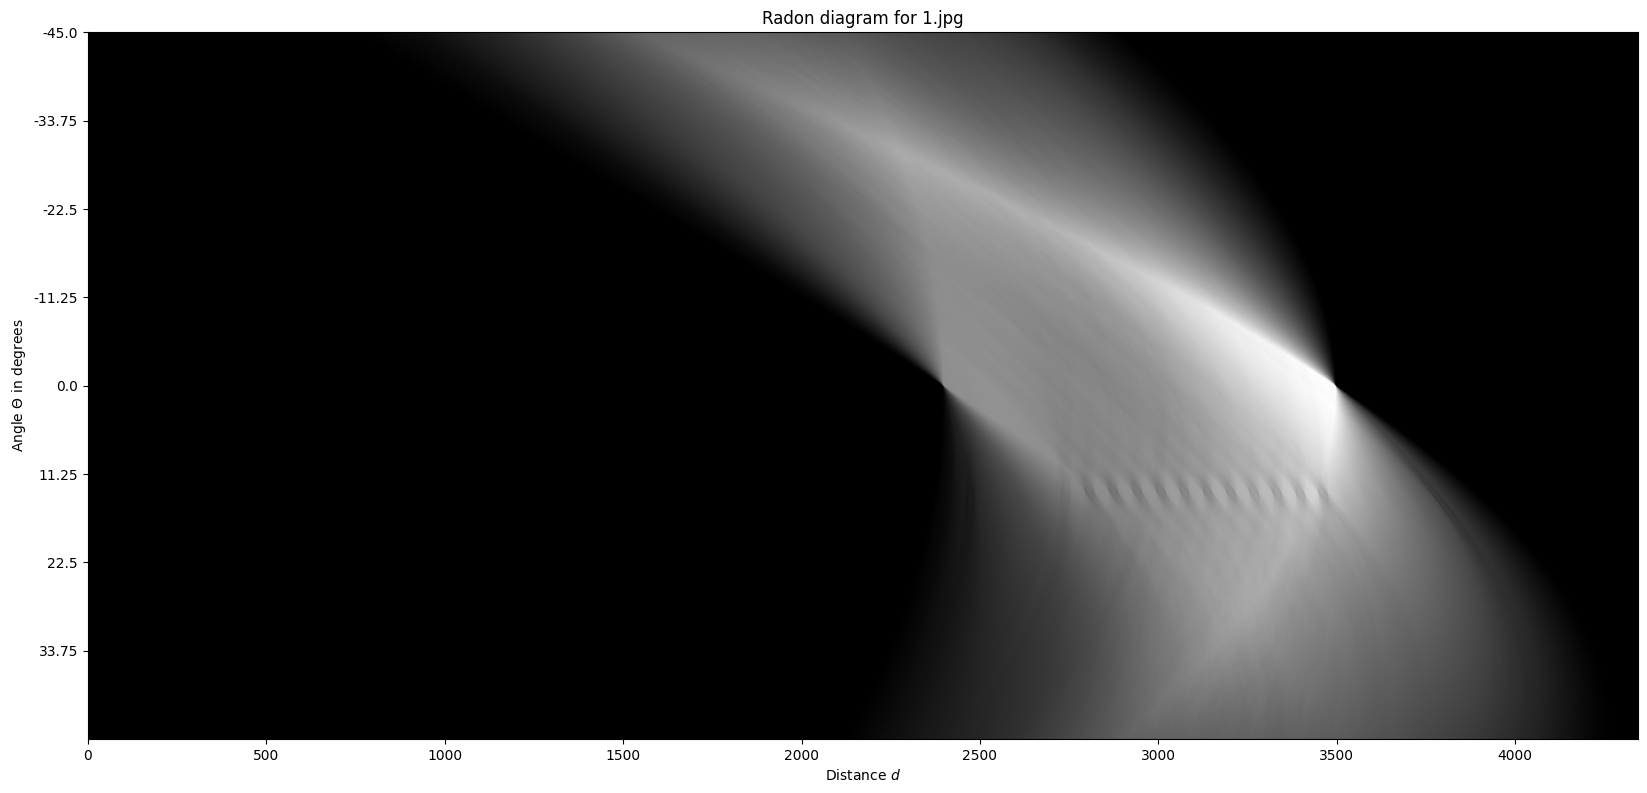

In [7]:
drt = cv.imread("drt.jpg")
plt.figure(figsize=(20,20))
plt.title(f"Radon diagram for {src_path.split('/')[-1]}")
plt.ylabel(r'Angle $\Theta$ in degrees')
plt.yticks(np.arange(0, drt.shape[0]+1, drt.shape[0]/8), labels=np.arange(-45, 45+1, 90/8))
plt.xlabel(r'Distance $d$')
plt.imshow(drt);

На полученной диаграмме Радона можно заметить чередующиеся полосы в нижней части изображения. Искомый угол наклона текста соответствует горизонтальной линии, проходящей через них. 

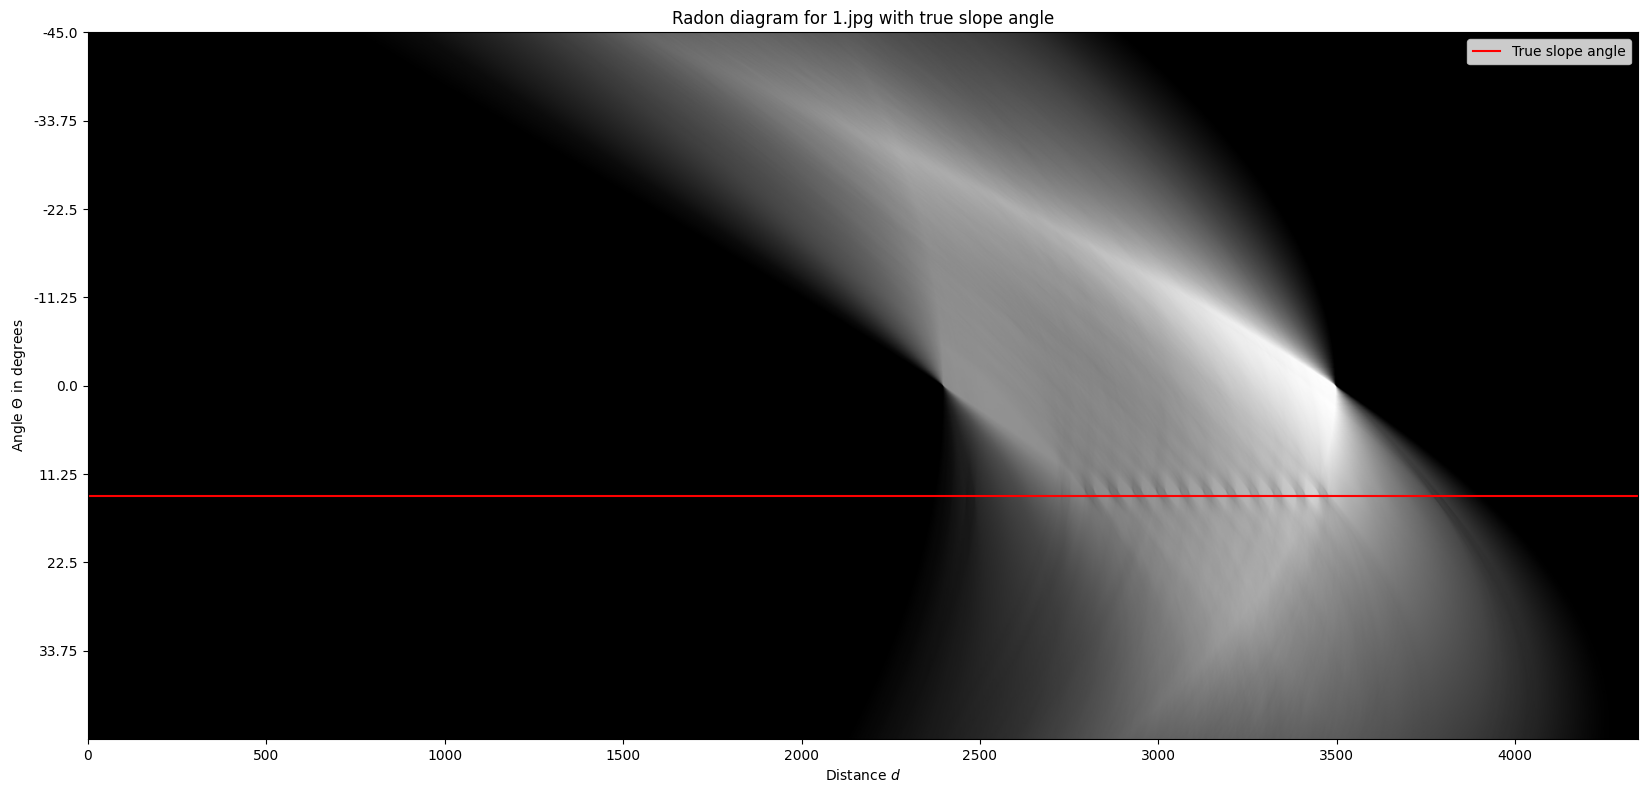

In [10]:
drt = cv.imread("drt.jpg")
plt.figure(figsize=(20,20))
plt.title(f"Radon diagram for {src_path.split('/')[-1]} with true slope angle")
plt.ylabel(r'Angle $\Theta$ in degrees')
plt.yticks(np.arange(0, drt.shape[0]+1, drt.shape[0]/8), labels=np.arange(-45, 45+1, 90/8))
plt.xlabel(r'Distance $d$')

slope_angle = 14
plt.axhline(y=slope_angle*(drt.shape[0]/90) + drt.shape[0]/2, color='r', linestyle='-', label='True slope angle')

plt.legend()
plt.imshow(drt);

Несмотря на то что подобные полосы хорошо детектируются визуально, алгоритмически найти их сложно: ни сумма квадратов, ни MSE-дисперсия в общем случае (и конкретно в этом) их не находят.

В качестве возможного решения перед MSE можно провести бинаризацию диаграммы, которая сделает пики более различимыми, однако этот порог будет очень чувствителен к входному изображению, и на практике подобный подход окажется непрактичным.

Другим решением является предобработка входного изображения, в частности полутоновая морфология в сочетании с фильтром Собеля (8 лекция), однако мне не удалось подобрать параметры, которые давали бы хорошие результаты. Основным препятствием здесь стало то, что подобные преобразования требуют указания направления (горизонтальное / вертикальное), которое в общем случае неизвестно и, более того, различно для разных документов.

Важное уточнение: я решал задачу в условиях, когда входное изображение может не иметь контура страницы, то есть пытался определить угол наклона только по содержимому страницы, так как в реальных данных такие случаи возможны. Если же известно, что на всех входных изображениях контуры страницы присутствуют, то избавление от текста в сочетании с горизонтальным и вертикальным фильтрами Собеля позволят получить контуры, диаграмма Радона которых будет иметь ярко выраженные пики, различимые суммой квадратов. 

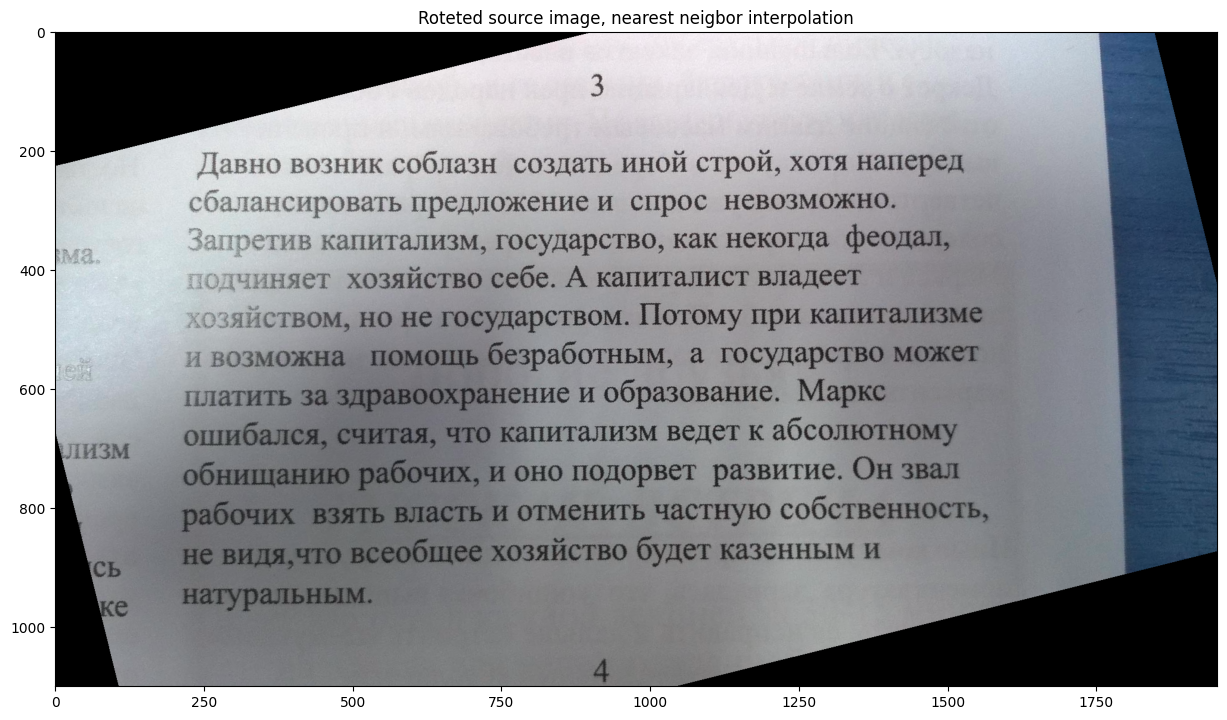

In [11]:
center = tuple(np.array(src.shape[1::-1]) / 2)
rot_mat = cv.getRotationMatrix2D(center, slope_angle, 1.0)
rotated = cv.warpAffine(src, rot_mat, src.shape[1::-1], flags=cv.INTER_NEAREST)

plt.figure(figsize=(15,15))
plt.title(f"Roteted source image, nearest neigbor interpolation")
plt.imshow(rotated);

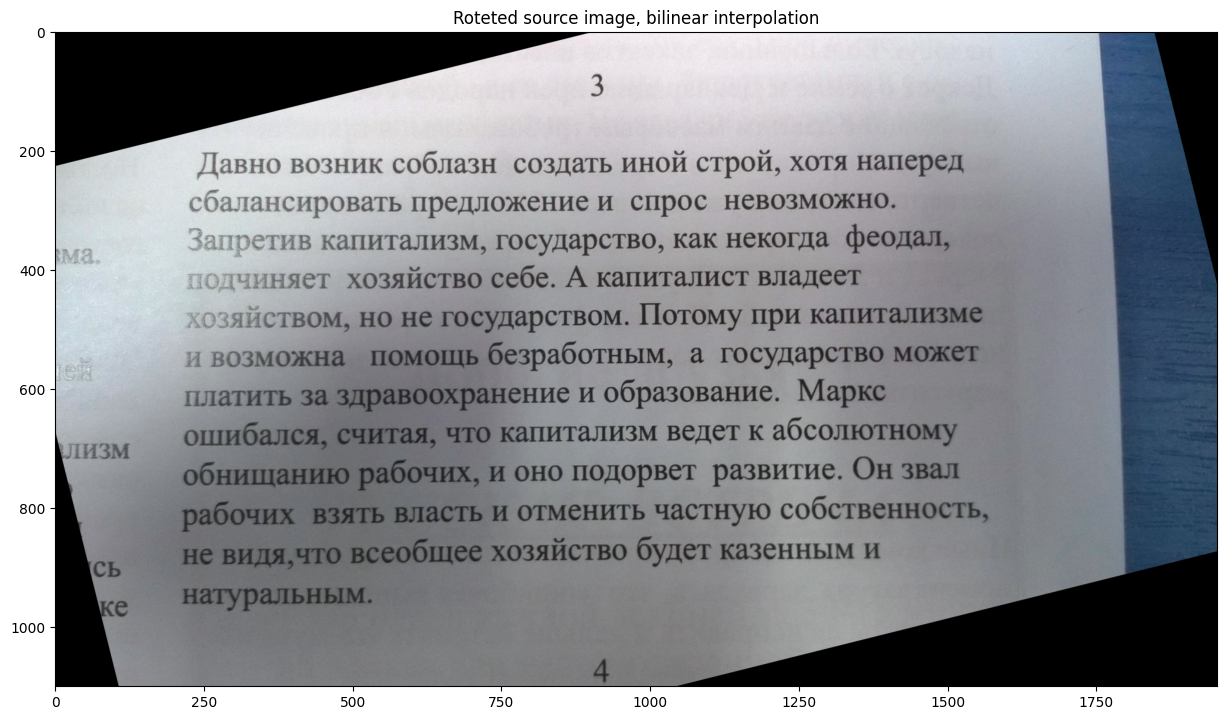

In [12]:
rotated = cv.warpAffine(src, rot_mat, src.shape[1::-1], flags=cv.INTER_LINEAR)

plt.figure(figsize=(15,15))
plt.title(f"Roteted source image, bilinear interpolation")
plt.imshow(rotated);

## Performance

In [15]:
big_src = cv.imread("images/8.jpg")
rows_cols_ratio = big_src.shape[1]/big_src.shape[0]
depth = big_src.shape[2]

megapixels = np.arange(1, big_src.size // 1e6 + 1, 1)
work_times = []

for megapixel in tqdm(megapixels):
    rows = np.sqrt(megapixel * 1e6 / (depth * rows_cols_ratio))
    cols = rows * rows_cols_ratio
    
    cv.imwrite("small.jpg", big_src[:int(rows), :int(cols), :])
    
    args = ["./cmake-build-debug/FHT", "small.jpg", "drt.jpg"]
    output = subprocess.run(args, shell=False, capture_output=True)
    work_times.append(int(output.stdout.decode("utf-8").split()[-2]))

100%|██████████| 34/34 [03:07<00:00,  5.51s/it]


In [16]:
!rm small.jpg

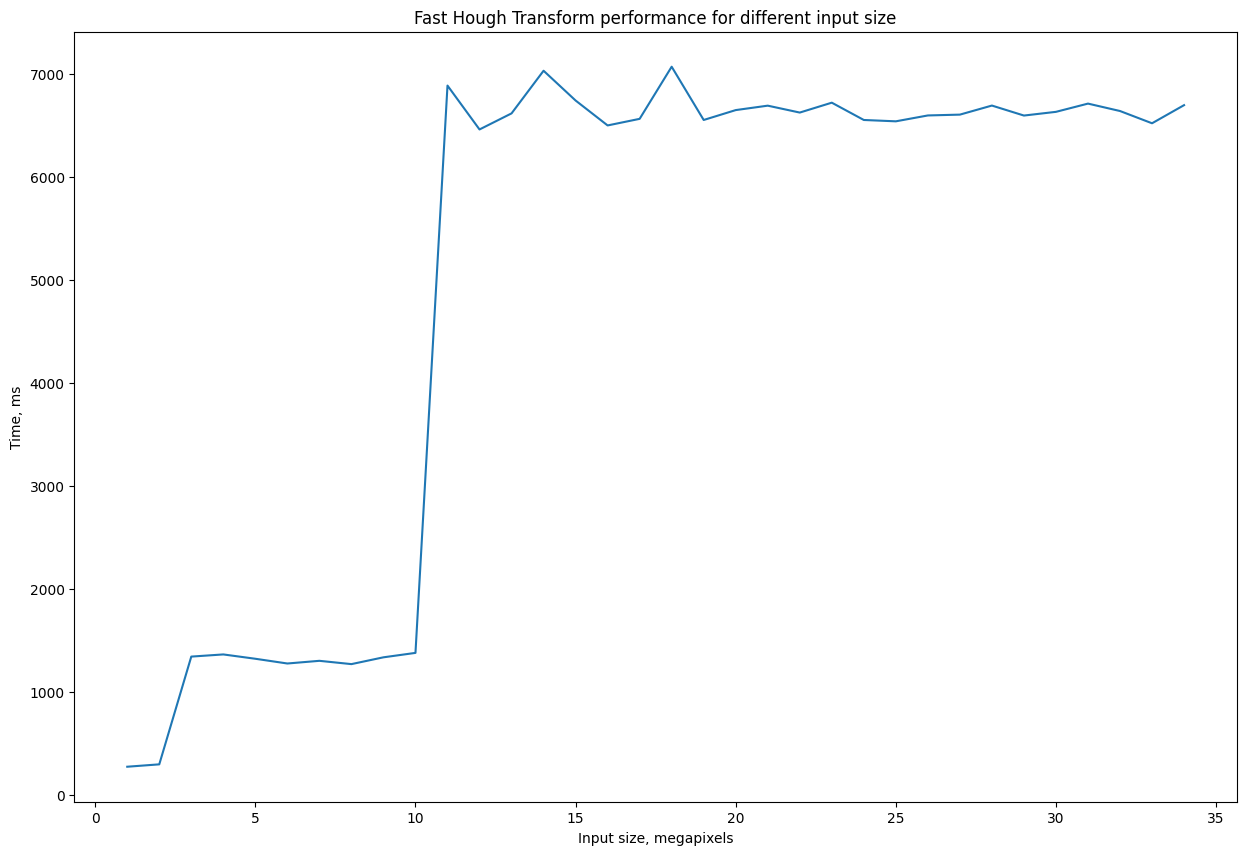

In [17]:
plt.figure(figsize=(15,10))

plt.plot(megapixels, work_times)

plt.title(f"Fast Hough Transform performance for different input size")
plt.ylabel('Time, ms')
plt.xlabel('Input size, megapixels')
plt.show()

Резкие скачки графика объясняются тем, что когда одна из размерностей входного изображения переваливает через степень двойки, быстрое преобразование Хафа требует увеличения размера изображения по каждой из осей до новой степени. Вычислительная сложность при дальнейшем увеличении входа в пределах этой степени остаётся прежней, поэтому после каждого скачка наблюдается плато.

## Performance estimation

Фактическая асимптотика алгоритма складывается из следующих этапов ($N$ - размерность входного изображения):

|этап                                                      | асимпт. память   | асимпт. вычисления    |
|----------------------------------------------------------|:----------------:|:---------------------:|
| Расширение изображения до ближайшей степени двойки       |     $N^2$        | $N^2$                 |
| Быстрое преобразование Хафа для одной четверти (x2)      |     $N^2$        | $N^2 \cdot\log N$     |
| Создание и заполнение диаграммы Радона                   |     $N^2$        | $N^2$                 |
| Вычисление угла поворота по диаграмме                    |      -           | $N^2$                 |

Итого $O(N^2)$ памяти и $O(N^2 \cdot\log N)$ вычислений.